# JOB-SHOP PROBLEM WITH SIMULATED ANNEALING

In [1]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Read Dataset

In [2]:
def read_data(file):
    df = pd.read_excel(file, header=None)
    matrix = []

    # Iterate over rows to process job data
    for job in df.itertuples(index=False):
        # Convert the row into pairs of (machine, time)
        row_data = list(job)
        job_data = {}
        for i in range(0, len(row_data), 2):
            machine = int(row_data[i])
            time = int(row_data[i+1])
            job_data[machine] = time
        matrix.append(job_data)

    result_df = pd.DataFrame(matrix).fillna(0).astype(int)
    return result_df

In [3]:
data = read_data("JSSP-problems/la01.xlsx")
data

,1,0,4,3,2
0,21,53,95,55,34
1,71,21,16,52,26
2,42,12,98,39,31
3,77,55,79,77,66
4,19,83,37,34,64
5,54,92,79,62,43
6,87,93,77,69,87
7,41,60,83,24,38
8,49,44,25,17,98
9,75,96,77,79,43


## Plot Functions

In [4]:
def plot_solution(chromosome, data):
    job_end_time = [0] * data.shape[0]  # End time for each job
    machine_end_time = [0] * data.shape[1]  # End time for each machine
    task_schedule = []  # To store the schedule for plotting
    num_machines = data.shape[1]
    num_jobs = data.shape[0]

    # Process the chromosome
    for job, machine in chromosome:
        start_time = max(job_end_time[job], machine_end_time[machine])
        end_time = start_time + data[machine][job]
        task_schedule.append((job, machine, start_time, end_time))  # Store the task details
        job_end_time[job] = end_time  # Update job end time
        machine_end_time[machine] = end_time  # Update machine end time

    fig, ax = plt.subplots(figsize=(10, 8))
    machine_colors = plt.cm.tab20.colors

    for job, machine, start_time, end_time in task_schedule:
        ax.barh(machine, end_time - start_time, left=start_time, color=machine_colors[job % 20])
 
    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f"M{m}" for m in range(num_machines)])
    ax.set_xlabel("Time")
    ax.set_ylabel("Machine")
    ax.set_title("Job-Shop Scheduling Solution")
    ax.invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Legend
    legend_patches = [
        mpatches.Patch(color=machine_colors[job % 20], label=f"Job {job}")
        for job in range(len(data))
    ]
    ax.legend(handles=legend_patches, title="Jobs", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


In [5]:
def plot_evolution(minimum_fitness_per_generation):
    generations = list(range(len(minimum_fitness_per_generation)))
    plt.figure(figsize=(10, 6))
    plt.plot(generations, minimum_fitness_per_generation, marker='o', label='Minimum Makespan')
    plt.title('Evolution of Minimum Makespan Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Minimum Makespan (Fitness)')
    plt.grid()
    plt.legend()
    plt.show()

## Fitness

In [6]:
def fitness(chromosome, data):
    job_end_time = [0] * data.shape[0]  # End time of each job
    machine_end_time = [0] * data.shape[1]  # End time of each machine
    
    for task in chromosome:
        job, machine = map(int, task)
        start_time = max(job_end_time[job], machine_end_time[machine]) # Start time of the task
        job_end_time[job] = start_time + data[machine][job] # Update end time of job
        machine_end_time[machine] = start_time + data[machine][job] # Update end time of machine
    
    return max(machine_end_time)  # Makespan

## Generate Initial Configuration

In [7]:
def initial_configuration(data):
    jobs = list(range(data.shape[0]))
    machines = list(range(data.shape[1]))
    chromosome = []
    
    for job in jobs:
        for machine in machines:
            chromosome.append((job, machine))
    
    random.shuffle(chromosome)
    return chromosome

## Get Neighbor

In [8]:
def get_neighbours(chromosome):
    neighbor = chromosome[:]
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]
    return neighbor

## Simulated Annealing

In [9]:
def simulated_annealing(data, params):
    initial_solution = initial_configuration(data)
    current_solution = initial_solution
    current_fitness = fitness(current_solution, data)
    best_solution = current_solution
    best_fitness = current_fitness

    initial_temperature = params["initial_temperature"]
    cooling_rate = params["cooling_rate"]
    max_iterations = params["max_iterations"]

    temperature = initial_temperature
    fitness_progression = [current_fitness]

    for iteration in range(max_iterations):
        # Generate a neighbor solution
        neighbor_solution = get_neighbours(current_solution)
        neighbor_fitness = fitness(neighbor_solution, data)

        # Calculate acceptance probability
        delta_fitness = neighbor_fitness - current_fitness
        acceptance_probability = math.exp(-delta_fitness / temperature) if delta_fitness > 0 else 1.0

        # Accept or reject the neighbor
        if random.random() < acceptance_probability:
            current_solution = neighbor_solution
            current_fitness = neighbor_fitness

            # Update the best solution found
            if current_fitness < best_fitness:
                best_solution = current_solution
                best_fitness = current_fitness

        # Cool down
        temperature *= cooling_rate

        fitness_progression.append(best_fitness)

        # Stop if temperature is too low
        if temperature < 1e-8:
            break

    return best_solution, best_fitness, fitness_progression

## Parameters

In [10]:
jobs, machines = data.shape
max_iterations = jobs * machines * 50
print(f"Max iterations: {max_iterations}")

params = {
    "initial_temperature": 1000, 
    "cooling_rate": 0.99,         
    "max_iterations": max_iterations    
}

Max iterations: 2500


In [11]:
best_solution, best_fitness, fitness_progression = simulated_annealing(data, params)
print("Best fitness:", best_fitness)

Best fitness: 666


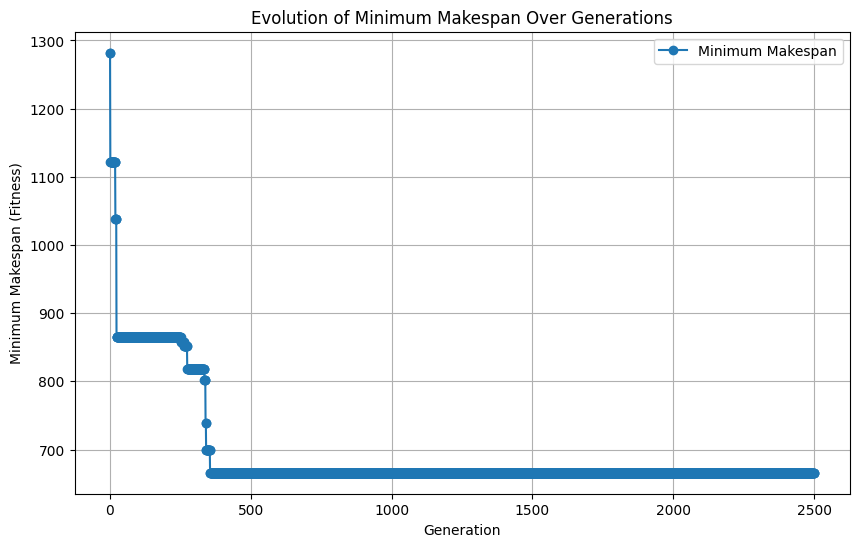

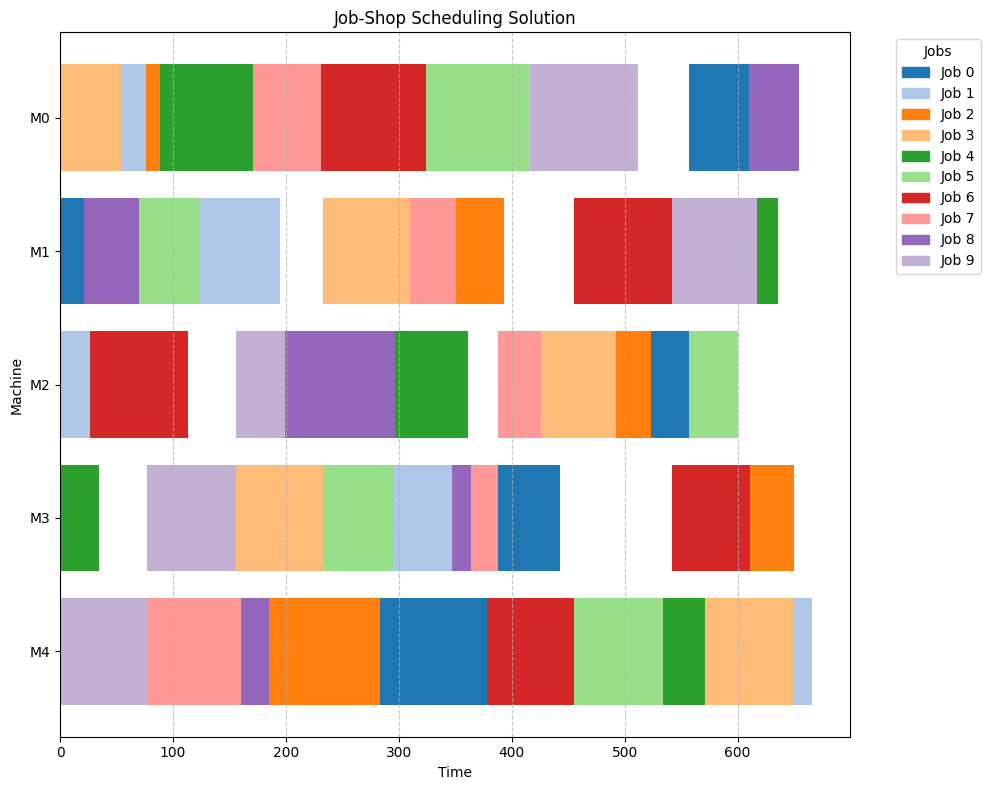

In [12]:
plot_evolution(fitness_progression)
plot_solution(best_solution, data)